## Library

In [1]:
!pip install transformers
!pip install sentence_transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=5f2cab4b76cb18764c07004556b9d6411aae486c837356a2ca6eac11329c9ea0
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.5 MB/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/classification

/content/drive/MyDrive/classification


In [2]:
from transformers import AutoModelForSequenceClassification,Trainer,AutoTokenizer,TrainingArguments
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score
from sklearn.model_selection import train_test_split

## Data pre-processing

In [3]:
dataset = "1"

if dataset == "1":

    #df = pd.read_excel("Constraint_Train.xlsx")
    df = pd.read_excel("./BERT/BERT/1/Constraint_Train.xlsx")
    test_df  = pd.read_excel("./BERT/BERT/1/Constraint_Test.xlsx")

elif dataset == "2":

    df = pd.read_excel("./BERT/BERT/2/texts_labeled_cleaned.xlsx")

    df.columns = ["tweet","label"]


    df,test_df = train_test_split(df,test_size=0.1,random_state=12)

elif dataset == "3":

    train = pd.read_csv('train.csv',delimiter='\t')
    test = pd.read_csv('test.csv',delimiter='\t')
    valid = pd.read_csv('valid.csv',delimiter='\t')

    replace_dict = {'half-true': 0, 'mostly-true': 0, 'false': 0, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

    train['false'] = train['false'].replace(replace_dict)

    test['true'] = test['true'].replace(replace_dict)

    valid['barely-true'] = valid['barely-true'].replace(replace_dict)

    value_counts = train['false'].value_counts()

    label_train = train['false'].tolist()
    label_test = test['true'].tolist()
    train_set = train['Says the Annies List political group supports third-trimester abortions on demand.'].tolist()
    test_set = test['Building a wall on the U.S.-Mexico border will take literally years.'].tolist()
    unlabeled = valid['We have less Americans working now than in the 70s.'].tolist()
    df = pd.DataFrame({"tweet" : train_set + test_set,
              "label" : label_train + label_test })

    test_df = pd.DataFrame({"tweet" : unlabeled} )




class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
encoder     = LabelEncoder()
df['label'] = encoder.fit_transform( df['label'] )
# test_df['label'] = encoder.transform(test_df['label'])

In [5]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy" : accuracy_score(labels,predictions),
            "f1"  : f1_score(labels,predictions),
            "precision"  : precision_score(labels,predictions)}

## Sanity Test

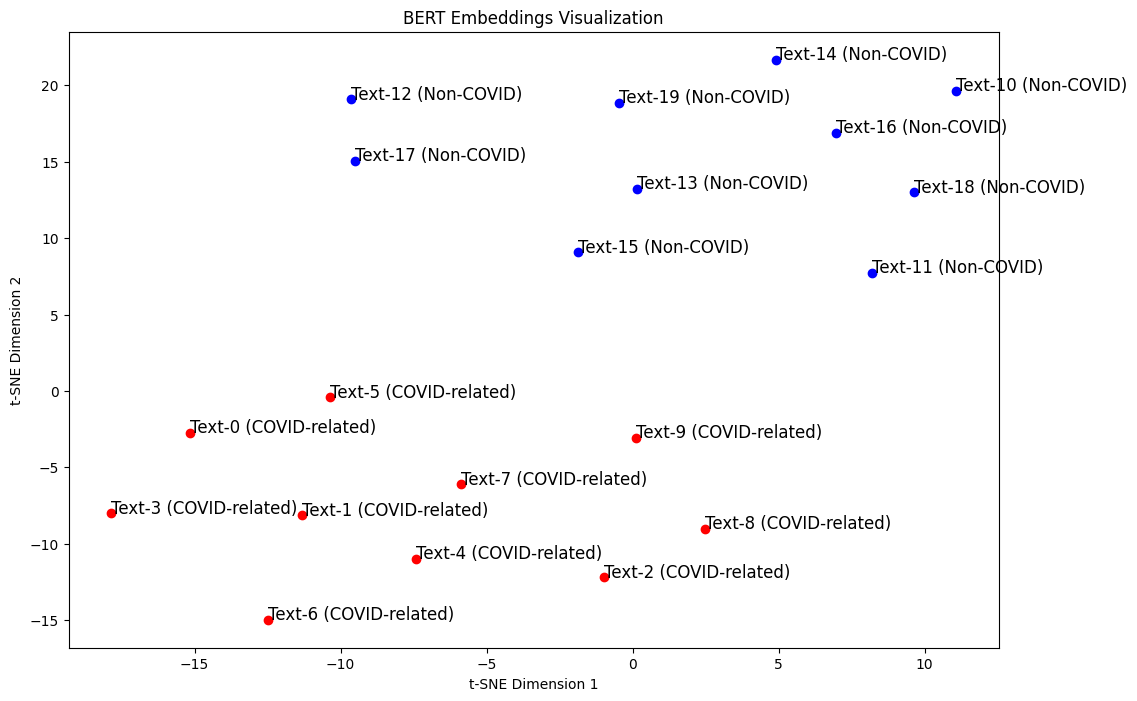

In [9]:
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# 初始化 BERT 模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
# 定义获取 BERT 嵌入的函数
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())
    return np.array(embeddings)

# 定义一小批示例文本和标签
texts = [
    # COVID-related sentences
    "The COVID-19 vaccine rollout is happening.",
    "COVID cases are spiking in my area.",
    "Due to the pandemic, the event was cancelled.",
    "What are the symptoms of the coronavirus?",
    "People are stockpiling hand sanitizers due to COVID.",
    "COVID-19 has impacted the global economy.",
    "Social distancing is key to stop the spread.",
    "Schools have been closed due to COVID-19.",
    "Many people have lost their jobs due to the pandemic.",
    "Healthcare workers are on the frontline.",

    # Non-COVID-related sentences
    "I like to play video games.",
    "She is going on a vacation to the mountains.",
    "I bought a new pair of shoes.",
    "The book I read was fantastic.",
    "I love Italian food.",
    "The movie was not that great.",
    "I like to listen to classical music.",
    "I bought a new phone.",
    "I love to travel and see new places.",
    "My dog is really cute.",
]

# Labels for these texts
labels = [1]*10 + [0]*10  # First 10 are COVID-related (1), next 10 are not (0)

# 获取 BERT 嵌入
embeddings = get_bert_embeddings(texts)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, perplexity=10, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# 进行可视化
plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    x, y = embeddings_2d[i]
    if label == 1:
        plt.scatter(x, y, c='r')
        plt.text(x, y, f"Text-{i} (COVID-related)", fontsize=12)
    else:
        plt.scatter(x, y, c='b')
        plt.text(x, y, f"Text-{i} (Non-COVID)", fontsize=12)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('BERT Embeddings Visualization')
plt.show()

## BERT classifier

In [5]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

id2label = {0 : 0 ,1 : 1 }
label2id = {0 : 0, 1 : 1 }

model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state=12)

In [ ]:
train_encoding =  tokenizer(train_df['tweet'].values.tolist(), truncation=True, padding=True)
val_encoding   = tokenizer(val_df['tweet'].values.tolist(), truncation=True, padding=True)
train_dataset = TextDataset(train_encoding,train_df['label'].values.tolist())
val_dataset   = TextDataset(val_encoding,val_df['label'].values.tolist())

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,No log,0.087417,0.974299,0.975930,0.986726
2,0.165400,0.079133,0.975078,0.977208,0.964838


TrainOutput(global_step=642, training_loss=0.14737719835893387, metrics={'train_runtime': 323.6204, 'train_samples_per_second': 31.741, 'train_steps_per_second': 1.984, 'total_flos': 2702676760657920.0, 'train_loss': 0.14737719835893387, 'epoch': 2.0})

## Embedding (original model）

In [7]:
from sentence_transformers import SentenceTransformer
model_name = "bert-base-uncased"
model = SentenceTransformer(model_name)

In [8]:
train_embedding = model.encode( train_df["tweet"].values.tolist() )
val_embedding   = model.encode( val_df["tweet"].values.tolist() )

In [ ]:
def compute_metrics(model_name,predict,true):
    return {
        "model_name" : model_name,
        "accuracy" : accuracy_score(true,predict),
        "f1" : f1_score(true,predict),
        "precision" : precision_score(true,predict)
    }

In [ ]:
train_embedding.shape

(5136, 768)

In [ ]:
val_embedding.shape

(1284, 768)

In [9]:
train_label = train_df["label"].tolist()
val_label   = val_df["label"].tolist()

## classical classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

In [ ]:
models = [KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,MLPClassifier]
result = []
for m in models:
    model = m()
    model.fit(train_embedding,
              train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics(m.__name__,
                                  val_predict,
                                  val_label))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("dataset:",dataset)

pd.DataFrame(result)

dataset: 1


,model_name,accuracy,f1,precision
0,KNeighborsClassifier,0.935358,0.941999,0.913279
1,LogisticRegression,0.945483,0.949857,0.943101
2,DecisionTreeClassifier,0.843458,0.854242,0.858601
3,MLPClassifier,0.959502,0.962644,0.958512


## KNN method

In [ ]:
from tqdm.auto import tqdm

Ks = [1,2,3,4,5,6,7,8,9,10,20,30]

result = []

for k in tqdm(Ks):
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(train_embedding,train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics("{}".format(k),
                                  val_predict,
                                  val_label))


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
knndf = pd.DataFrame(result)

knndf.columns = ["K","accuracy","f1","precision"]
knndf.index = knndf.K

knndf = knndf.drop(columns = ["K"])
knndf

,accuracy,f1,precision
K,,,
1,0.943146,0.948700,0.924658
2,0.947040,0.950509,0.958884
3,0.942368,0.947814,0.926897
4,0.947040,0.951220,0.945792
5,0.935358,0.941999,0.913279
6,0.943925,0.948936,0.933054
7,0.934579,0.941423,0.910931
8,0.942368,0.947887,0.925722
9,0.933801,0.941176,0.904255


<Axes: xlabel='K'>

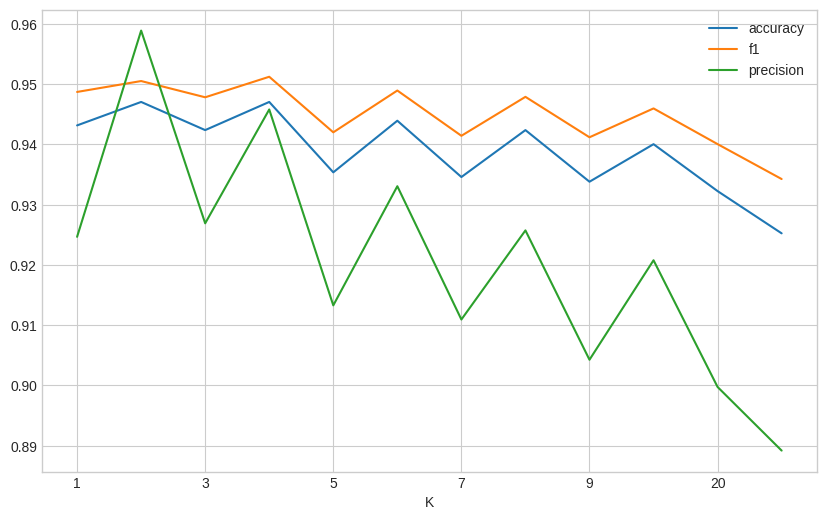

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

fig,ax = plt.subplots(1,1,figsize=(10,6))
knndf.plot(ax = ax)

## CNN realization

In [10]:
X_train = torch.tensor(train_embedding, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(val_embedding, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.float32).unsqueeze(1)

In [11]:
class FakeNewsClassifierCNN(nn.Module):
    def __init__(self):
        super(FakeNewsClassifierCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduce dimension by half: 16x12

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduce dimension to: 8x6

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 6, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Reshape input for CNN: (batch_size, 1, 32, 24)
        x = x.view(-1, 1, 32, 24)

        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
import torch
import torch.nn as nn
import numpy as np
import random

# 设置随机种子以获得可重复的结果
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 注意：这可能会稍微降低运行速度
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型
model = FakeNewsClassifierCNN().to(device)  # 确保模型在GPU上

# 定义损失和优化器
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# 训练循环
num_epochs = 200  # 您可以根据需要更改epochs的数量

best_accuracy = 0  # 保存最高准确率

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # 训练阶段
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 数据移至GPU

        optimizer.zero_grad()

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

    # 验证阶段
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 数据移至GPU
            outputs = model(batch_x)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    current_accuracy = correct/total*100
    print(f"Accuracy on validation data: {current_accuracy:.2f}%")

    # 如果当前准确率高于迄今为止的最高准确率，则保存此准确率
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy

print(f"Highest Accuracy on validation data: {best_accuracy:.2f}%")


Epoch 1/200, Loss: 0.4243054202069407
Accuracy on validation data: 83.96%
Epoch 2/200, Loss: 0.3249191124431835
Accuracy on validation data: 89.88%
Epoch 3/200, Loss: 0.2778312444501782
Accuracy on validation data: 90.97%
Epoch 4/200, Loss: 0.2654759671932422
Accuracy on validation data: 92.83%
Epoch 5/200, Loss: 0.25776778684454676
Accuracy on validation data: 92.60%
Epoch 6/200, Loss: 0.2535909408275385
Accuracy on validation data: 93.54%
Epoch 7/200, Loss: 0.24788203562453667
Accuracy on validation data: 93.38%
Epoch 8/200, Loss: 0.238133246993056
Accuracy on validation data: 93.93%
Epoch 9/200, Loss: 0.23746440087601264
Accuracy on validation data: 94.24%
Epoch 10/200, Loss: 0.22420088757084022
Accuracy on validation data: 93.46%
Epoch 11/200, Loss: 0.21866845612570365
Accuracy on validation data: 93.77%
Epoch 12/200, Loss: 0.21384977040268618
Accuracy on validation data: 93.69%
Epoch 13/200, Loss: 0.21887413789489255
Accuracy on validation data: 93.61%
Epoch 14/200, Loss: 0.211920

In [14]:
X_train = torch.tensor(train_embedding, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.long)
X_val = torch.tensor(val_embedding, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.long)

In [15]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # you might have more layers here
            nn.Linear(hidden_dim, output_dim)  # This should ensure the final output has shape (N, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x  # No softmax here, CrossEntropyLoss expects raw scores (logits)

In [18]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# 设置随机种子以获得可重复的结果
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 注意：这可能会稍微降低运行速度
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 参数设置
input_dim = 768
hidden_dim = 256
output_dim = 2  # 二分类

# 实例化模型并移至设备
model = MLPClassifier(input_dim, hidden_dim, output_dim).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(num_epochs, save_best_model=False):
    model.train()

    best_val_accuracy = 0  # 追踪最高的验证准确率
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # 在每个epoch结束后，都用验证集来评估模型
        current_val_accuracy = validate_model()
        if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy
            if save_best_model:
                # 如果这个epoch的模型在验证集上达到了新的最佳表现，就保存模型
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"Detected model improvement, saving current model to 'best_model.pth'")

    print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')


def validate_model():
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_y).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = 100 * correct_predictions / total_predictions
    return accuracy  # 现在，这个函数返回当前的准确率

# 你可以选择是否在每个epoch后保存最佳模型
num_epochs = 200
train_model(num_epochs, save_best_model=True)

Epoch [1/200], Loss: 0.2357
Detected model improvement, saving current model to 'best_model.pth'
Epoch [2/200], Loss: 0.1671
Detected model improvement, saving current model to 'best_model.pth'
Epoch [3/200], Loss: 0.1463
Epoch [4/200], Loss: 0.1321
Epoch [5/200], Loss: 0.1127
Detected model improvement, saving current model to 'best_model.pth'
Epoch [6/200], Loss: 0.1050
Epoch [7/200], Loss: 0.0904
Detected model improvement, saving current model to 'best_model.pth'
Epoch [8/200], Loss: 0.0867
Epoch [9/200], Loss: 0.0748
Detected model improvement, saving current model to 'best_model.pth'
Epoch [10/200], Loss: 0.0718
Epoch [11/200], Loss: 0.0618
Detected model improvement, saving current model to 'best_model.pth'
Epoch [12/200], Loss: 0.0697
Detected model improvement, saving current model to 'best_model.pth'
Epoch [13/200], Loss: 0.0444
Epoch [14/200], Loss: 0.0416
Epoch [15/200], Loss: 0.0324
Epoch [16/200], Loss: 0.0299
Epoch [17/200], Loss: 0.0323
Epoch [18/200], Loss: 0.0255
Epoc

## MLM fine-tuning (self-supervision)

In [10]:
# Load the Constraint_Test dataset
constraint_test_df = test_df


# Use the tweet column for fine-tuning
unlabeled_texts = constraint_test_df["tweet"].tolist()

from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Load the pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# Tokenize the texts
encodings = tokenizer(unlabeled_texts, truncation=True, padding='max_length', max_length=512, return_tensors='pt')

# Custom dataset class for MLM
class MLM_Dataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].detach().clone()
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create a DataLoader using the encodings
dataset = MLM_Dataset(encodings)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

# Training arguments and Trainer
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    logging_dir='./logs',
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Fine-tune the model using the unlabeled data
trainer.train()

# Save the fine-tuned model
model_directory = "/content/drive/MyDrive/classification/BERT/BERT/1/fine_tuned_model"
model.save_pretrained(model_directory)

# Save the tokenizer
tokenizer.save_pretrained(model_directory)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-10-379d9cd4ae98>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss


('/content/drive/MyDrive/classification/BERT/BERT/1/fine_tuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/classification/BERT/BERT/1/fine_tuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/classification/BERT/BERT/1/fine_tuned_model/vocab.txt',
 '/content/drive/MyDrive/classification/BERT/BERT/1/fine_tuned_model/added_tokens.json')

## Embedding methods (using MLM fine-tuned models)

In [18]:
from sentence_transformers import SentenceTransformer, models
# 加载微调后的模型
transformers_model_path = "/content/drive/MyDrive/classification/BERT/BERT/1/fine_tuned_model"

In [19]:
# 创建sentence-transformers模型
word_embedding_model = models.Transformer(transformers_model_path, model_args={'output_hidden_states': True})
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
sentence_transformer_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/classification/BERT/BERT/1/fine_tuned_model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Obtain embeddings for train and validation sets
train_embedding_finetuned = sentence_transformer_model.encode(train_df["tweet"].values.tolist())
val_embedding_finetuned = sentence_transformer_model.encode(val_df["tweet"].values.tolist())

# Define labels
train_label = train_df["label"].tolist()
val_label = val_df["label"].tolist()

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

In [22]:
def compute_metrics(model_name,predict,true):
    return {
        "model_name" : model_name,
        "accuracy" : accuracy_score(true,predict),
        "f1" : f1_score(true,predict),
        "precision" : precision_score(true,predict)
    }

In [23]:
models = [KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,MLPClassifier]
result = []
for m in models:
    model = m()
    model.fit(train_embedding_finetuned,
              train_label)

    val_predict = model.predict(val_embedding_finetuned)

    result.append(compute_metrics(m.__name__,
                                  val_predict,
                                  val_label))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
print("dataset:",dataset)

pd.DataFrame(result)

dataset: <__main__.MLM_Dataset object at 0x7d10c5fc1420>


,model_name,accuracy,f1,precision
0,KNeighborsClassifier,0.945483,0.950912,0.924966
1,LogisticRegression,0.948598,0.952790,0.944681
2,DecisionTreeClassifier,0.849688,0.861251,0.858166
3,MLPClassifier,0.951713,0.955331,0.953957


In [ ]:
from tqdm.auto import tqdm

Ks = [1,2,3,4,5,6,7,8,9,10,20,30]

result = []

for k in tqdm(Ks):
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(train_embedding_finetuned,train_label)

    val_predict = model.predict(val_embedding_finetuned)

    result.append(compute_metrics("{}".format(k),
                                  val_predict,
                                  val_label))


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
knndf = pd.DataFrame(result)

knndf.columns = ["K","accuracy","f1","precision"]
knndf.index = knndf.K

knndf = knndf.drop(columns = ["K"])
knndf

,accuracy,f1,precision
K,,,
1,0.944704,0.949681,0.933148
2,0.950935,0.953778,0.970149
3,0.940810,0.946479,0.924347
4,0.954050,0.957706,0.951567
5,0.945483,0.950912,0.924966
6,0.953271,0.957265,0.945148
7,0.947819,0.953048,0.926431
8,0.954829,0.958807,0.944056
9,0.949377,0.954514,0.926630


<Axes: xlabel='K'>

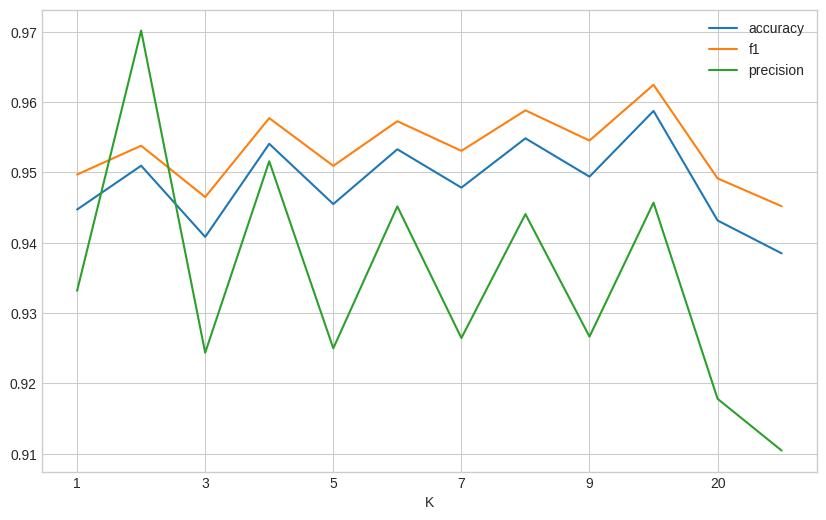

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

fig,ax = plt.subplots(1,1,figsize=(10,6))
knndf.plot(ax = ax)

In [25]:
X_train = torch.tensor(train_embedding_finetuned, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(val_embedding_finetuned, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.float32).unsqueeze(1)

In [26]:
class FakeNewsClassifierCNN(nn.Module):
    def __init__(self):
        super(FakeNewsClassifierCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduce dimension by half: 16x12

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduce dimension to: 8x6

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 6, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Reshape input for CNN: (batch_size, 1, 32, 24)
        x = x.view(-1, 1, 32, 24)

        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [27]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
import torch
import torch.nn as nn
import numpy as np
import random

# 设置随机种子以获得可重复的结果
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 注意：这可能会稍微降低运行速度
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型
model = FakeNewsClassifierCNN().to(device)  # 确保模型在GPU上

# 定义损失和优化器
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# 训练循环
num_epochs = 200  # 您可以根据需要更改epochs的数量

best_accuracy = 0  # 保存最高准确率

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # 训练阶段
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 数据移至GPU

        optimizer.zero_grad()

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

    # 验证阶段
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 数据移至GPU
            outputs = model(batch_x)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    current_accuracy = correct/total*100
    print(f"Accuracy on validation data: {current_accuracy:.2f}%")

    # 如果当前准确率高于迄今为止的最高准确率，则保存此准确率
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy

print(f"Highest Accuracy on validation data: {best_accuracy:.2f}%")

Epoch 1/200, Loss: 0.44695247080385314
Accuracy on validation data: 90.26%
Epoch 2/200, Loss: 0.33137898804238125
Accuracy on validation data: 92.91%
Epoch 3/200, Loss: 0.30383106904185336
Accuracy on validation data: 93.54%
Epoch 4/200, Loss: 0.2772801411077843
Accuracy on validation data: 93.30%
Epoch 5/200, Loss: 0.2784300470574302
Accuracy on validation data: 93.69%
Epoch 6/200, Loss: 0.2737431432704748
Accuracy on validation data: 93.93%
Epoch 7/200, Loss: 0.2606221673929173
Accuracy on validation data: 93.46%
Epoch 8/200, Loss: 0.25687189224343865
Accuracy on validation data: 93.61%
Epoch 9/200, Loss: 0.2524861585094322
Accuracy on validation data: 93.77%
Epoch 10/200, Loss: 0.23855274739842977
Accuracy on validation data: 94.00%
Epoch 11/200, Loss: 0.23586242229486845
Accuracy on validation data: 93.54%
Epoch 12/200, Loss: 0.23204455793089007
Accuracy on validation data: 93.22%
Epoch 13/200, Loss: 0.22610635949032648
Accuracy on validation data: 94.31%
Epoch 14/200, Loss: 0.2339

In [30]:
X_train = torch.tensor(train_embedding_finetuned, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.long)
X_val = torch.tensor(val_embedding_finetuned, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.long)

In [31]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # you might have more layers here
            nn.Linear(hidden_dim, output_dim)  # This should ensure the final output has shape (N, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x  # No softmax here, CrossEntropyLoss expects raw scores (logits)

In [32]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [33]:
# 设置随机种子以获得可重复的结果
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 注意：这可能会稍微降低运行速度
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 参数设置
input_dim = 768
hidden_dim = 256
output_dim = 2  # 二分类

# 实例化模型并移至设备
model = MLPClassifier(input_dim, hidden_dim, output_dim).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(num_epochs, save_best_model=False):
    model.train()

    best_val_accuracy = 0  # 追踪最高的验证准确率
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # 在每个epoch结束后，都用验证集来评估模型
        current_val_accuracy = validate_model()
        if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy
            if save_best_model:
                # 如果这个epoch的模型在验证集上达到了新的最佳表现，就保存模型
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"Detected model improvement, saving current model to 'best_model.pth'")

    print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')


def validate_model():
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_y).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = 100 * correct_predictions / total_predictions
    return accuracy  # 现在，这个函数返回当前的准确率

# 你可以选择是否在每个epoch后保存最佳模型
num_epochs = 200
train_model(num_epochs, save_best_model=True)

Epoch [1/200], Loss: 0.2601
Detected model improvement, saving current model to 'best_model.pth'
Epoch [2/200], Loss: 0.1867
Detected model improvement, saving current model to 'best_model.pth'
Epoch [3/200], Loss: 0.1674
Detected model improvement, saving current model to 'best_model.pth'
Epoch [4/200], Loss: 0.1613
Epoch [5/200], Loss: 0.1432
Epoch [6/200], Loss: 0.1339
Epoch [7/200], Loss: 0.1259
Epoch [8/200], Loss: 0.1256
Epoch [9/200], Loss: 0.1188
Detected model improvement, saving current model to 'best_model.pth'
Epoch [10/200], Loss: 0.1012
Epoch [11/200], Loss: 0.1008
Detected model improvement, saving current model to 'best_model.pth'
Epoch [12/200], Loss: 0.1034
Epoch [13/200], Loss: 0.0970
Detected model improvement, saving current model to 'best_model.pth'
Epoch [14/200], Loss: 0.0873
Epoch [15/200], Loss: 0.0722
Epoch [16/200], Loss: 0.0732
Epoch [17/200], Loss: 0.0659
Epoch [18/200], Loss: 0.0646
Epoch [19/200], Loss: 0.0608
Detected model improvement, saving current m